# Some takeaways:

1. 7.6M complains submitted to 30 agencies in 225 categories over 3238 days 
2. Noise tops as the complaint category with 1.3M records, followed by heat/hot water
3. weather might has affect in categories like heat, air quality and traffic
4. HYPD handles the most (28%) complains followed by HPD
5. Only 3 weather readers cover NYC for all the 3238 days
6. Complains have strong weekly seasonality
7. Daily change of complaints numbers is rightly skewed - Expect days with "abnormal" increase of complaints 

In [2]:
import pandas as pd
import dask.dataframe as dd
import warnings; warnings.simplefilter('ignore')


df_311_sample = pd.read_csv('Downloads/311-2016-2018.csv', nrows=1)
df_311_sample

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,Created Year
0,38237851,01/17/2018 02:39:00 PM,01/24/2018 12:00:00 AM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Sidewalk,11222,95 GREENPOINT AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.730013,-73.956267,"(40.73001299919553, -73.95626650502489)",2018


In [3]:
weather_data = pd.read_csv('Downloads/weather_NY_2010_2018Nov.csv')
weather_data['date'] = weather_data['Year'].apply(str)+weather_data['Month'].apply(str).apply(lambda x:x.zfill(2))+weather_data['Day'].apply(str).apply(lambda x:x.zfill(2))
weather_data['date'] = list(map(lambda x: pd.to_datetime(x),weather_data['date']))
weather_data.isnull().sum()
weather_data.head()

,USAF,WBAN,StationName,State,Latitude,Longitude,MeanTemp,MinTemp,MaxTemp,DewPoint,...,WindSpeed,MaxSustainedWind,Gust,Rain,SnowDepth,SnowIce,Year,Month,Day,date
0,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,27.6,24.8,30.9,25.0,...,1.3,6.0,NaN,0,NaN,1,2010,1,1,2010-01-01
1,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,-3.2,-20.9,17.1,-9.6,...,3.3,9.9,NaN,0,NaN,1,2010,1,10,2010-01-10
2,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,20.9,17.1,24.1,15.1,...,6.8,12.0,19.0,0,NaN,1,2010,1,11,2010-01-11
3,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,13.8,5.0,19.9,8.5,...,4.4,8.0,15.9,0,NaN,1,2010,1,12,2010-01-12
4,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,6.3,-8.0,19.0,1.9,...,3.3,5.1,NaN,0,NaN,1,2010,1,13,2010-01-13


In [4]:
import dask.dataframe as dd

df = dd.read_csv(
    'Downloads/311-2016-2018.csv',
    dtype={'Incident Zip': 'object'},
    blocksize=16 * 1024 * 1024, # 16MB chunks
)

def get_nrows(df):
    return df['Unique Key'].shape[0]

def get_null(df, col):
    return df[col].isnull().sum()

def get_unique(df, col):
    return df[col].unique()

result = get_nrows(df)
result = result.compute(num_workers=4)
print('nrows', result)

nrows 7631721


array([[<AxesSubplot:title={'center':'Agency'}>]], dtype=object)

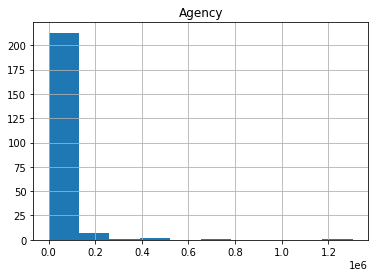

In [26]:
col =['Agency', 'Complaint Type']
df = dd.read_csv(
    'Downloads/311-2016-2018.csv',
    blocksize=16 * 1024 * 1024,
    usecols=col,
)

def get_complaint(df):
    res = df.groupby('Agency')['Complaint Type'].agg(list)
    return res
def per_complaint_type(df):
    df['Complaint Type'] = df['Complaint Type'].apply(lambda x:x.lower().split('-')[0].strip())
    res = df.groupby('Complaint Type').count()
    return res
result = per_complaint_type(df)
result = result.compute(num_workers=4)

result.sort_values('Agency').hist()

<AxesSubplot:ylabel='Complaint Type'>

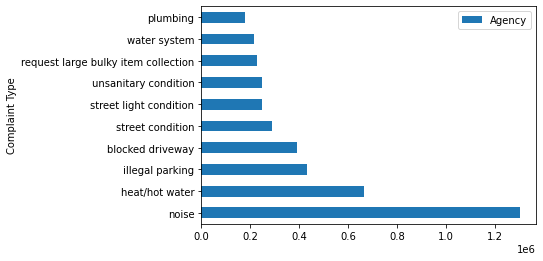

In [40]:
result.sort_values('Agency',ascending=False).iloc[:10].plot(kind='barh')

In [28]:
result.shape

(225, 1)

In [32]:
result[result.index=='air quality']

,Agency
Complaint Type,
air quality,23910


In [42]:
result.sort_values('Agency',ascending=False)/result.sum()

,Agency
Complaint Type,
noise,1.709745e-01
heat/hot water,8.717758e-02
illegal parking,5.662091e-02
blocked driveway,5.142457e-02
street condition,3.774221e-02
...,...
open flame permit,1.310320e-07
injured wildlife,1.310320e-07
illegal animal,1.310320e-07


In [37]:
for i in result.index:
    print(i)#.sort_values('Agency',ascending=False).iloc[:20]

advocate
air quality
alzheimer's care
animal abuse
animal in a park
appliance
asbestos
beach/pool/sauna complaint
bereavement support group
best/site safety
bike/roller/skate chronic
blocked driveway
boilers
bridge condition
broken parking meter
building/use
bus stop shelter complaint
bus stop shelter placement
collection truck noise
consumer complaint
curb condition
damaged tree
day care
dead/dying tree
derelict bicycle
derelict vehicle
derelict vehicles
dirty conditions
disorderly youth
dof property
door/window
dpr internal
drie
drinking
drinking water
drug activity
electric
electrical
electronics waste
elevator
emergency response team (ert)
fcst
flooring/stairs
food establishment
food poisoning
for hire vehicle complaint
for hire vehicle report
forms
found property
general
general construction/plumbing
graffiti
hazardous materials
heat/hot water
highway condition
home delivered meal
homeless encampment
homeless person assistance
housing
housing options
illegal animal kept as pet
ill

In [43]:
23910/result.sum()

Agency    0.003133
dtype: float64

In [9]:
cols = ["Latitude", "Longitude",
       'Unique Key']
df = dd.read_csv(
    'Downloads/311-2016-2018.csv',
    blocksize=16 * 1024 * 1024, # 16MB chunks
    usecols=cols,
)

def calls_by_geo(df):
    by_geo = df.groupby(["Latitude", "Longitude"])['Unique Key'].count()
    return by_geo

result = calls_by_geo(df)
result = result.compute(num_workers=4)
result = result.to_frame().reset_index()

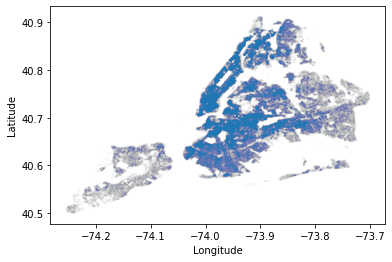

In [10]:
ax = result.plot.scatter(x='Longitude',
                y='Latitude',
               s=(result['Unique Key'])/(10**6));

tmp = weather_data.groupby(['Latitude','Longitude'])['date'].nunique()
tmp = tmp[tmp==3238].to_frame().reset_index()
#tmp.plot.scatter('Longitude','Latitude', ax=ax, c='r')

In [11]:
result.describe()

,Latitude,Longitude,Unique Key
count,944874.000000,944874.000000,944874.000000
mean,40.704562,-73.923980,7.454614
std,0.083569,0.104272,29.962820
min,40.498044,-74.255211,1.000000
25%,40.639465,-73.979860,1.000000
50%,40.697825,-73.922168,2.000000
75%,40.758085,-73.853299,6.000000
max,40.912941,-73.700384,7965.000000


In [12]:
tmp = tmp[(tmp['Latitude']<40.912941) & (tmp['Latitude']>40.498044) & (tmp['Longitude']>-74.255211) & (tmp['Longitude']<-73.700384)]

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

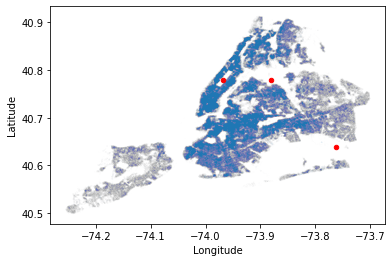

In [13]:
ax = result.plot.scatter(x='Longitude',
                y='Latitude',
               s=(result['Unique Key'])/(10**6));

tmp = weather_data.groupby(['Latitude','Longitude'])['date'].nunique()
tmp = tmp[tmp==3238].to_frame().reset_index()
tmp = tmp[(tmp['Latitude']<40.912941) & (tmp['Latitude']>40.498044) & (tmp['Longitude']>-74.255211) & (tmp['Longitude']<-73.700384)]
tmp.plot.scatter('Longitude','Latitude', ax=ax, c='r')

In [14]:
col =['Created Date', 'Agency', 'Complaint Type']
df = dd.read_csv(
    'Downloads/311-2016-2018.csv',
    blocksize=16 * 1024 * 1024,
    usecols=col,
)

def process(df):
    df['Created Date'] = df['Created Date'].map(lambda x:x.split()[0])
    res = df.groupby(['Created Date','Agency'])['Complaint Type'].count()
    return res
def count_complaint(df):
    df['Complaint Type'] = df['Complaint Type'].apply(lambda x:x.lower())
    res = df.groupby('Complaint Type').count()
    return res
result = process(df)
result = result.compute(num_workers=4)

<AxesSubplot:>

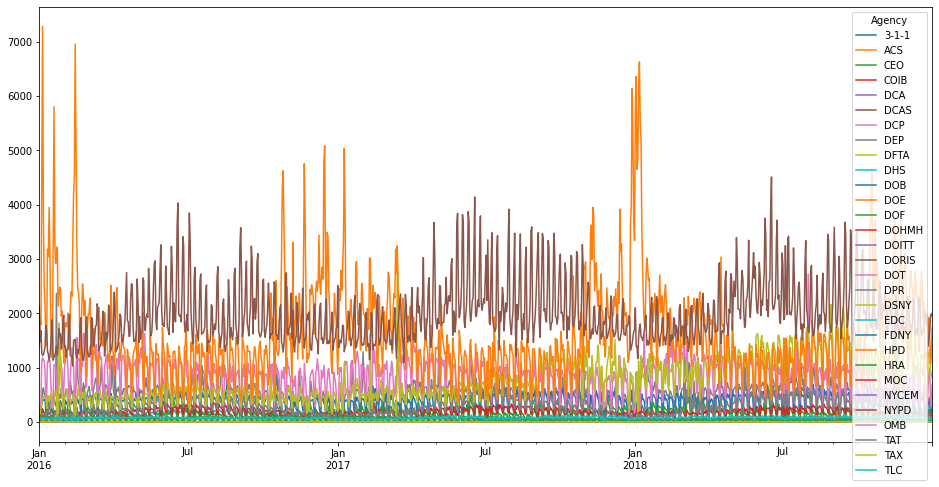

In [15]:
res = result.reset_index().pivot(index='Created Date',
                          columns='Agency',
                          values='Complaint Type').fillna(0)
res.index = list(map(lambda x: pd.to_datetime(x,format='%m/%d/%Y'),res.index))
res = res.sort_index()
res.plot(figsize=(16,8))

<AxesSubplot:ylabel='Agency'>

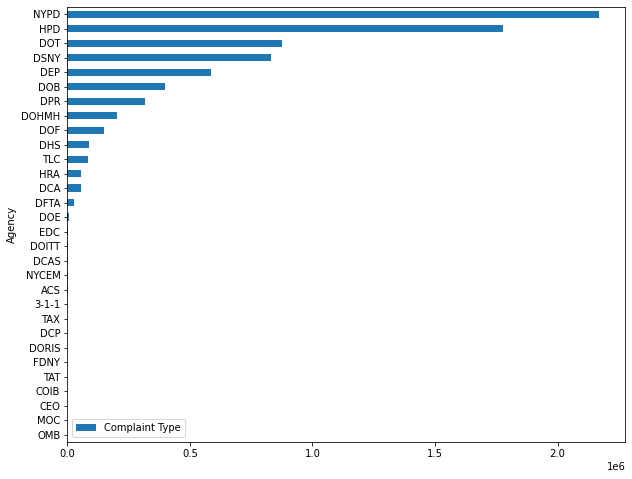

In [16]:
result.to_frame().reset_index().groupby('Agency').sum().sort_values('Complaint Type').plot(kind='barh'
                                                                                          ,figsize=(10,8))

In [17]:
(result.to_frame().reset_index().groupby('Agency').sum().sort_values('Complaint Type')/result.sum())

,Complaint Type
Agency,
OMB,2.620641e-07
MOC,2.620641e-07
CEO,6.551602e-07
COIB,2.096513e-06
TAT,2.358577e-06
FDNY,7.861923e-06
DORIS,8.779147e-06
DCP,9.827403e-06
TAX,4.048890e-05


In [18]:
result.sum()#.to_frame().reset_index().groupby('Agency').sum().sum().values[0]

7631721

<AxesSubplot:>

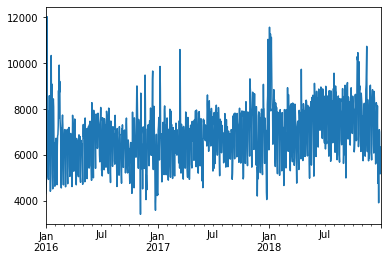

In [19]:
res.sum(axis=1).plot()

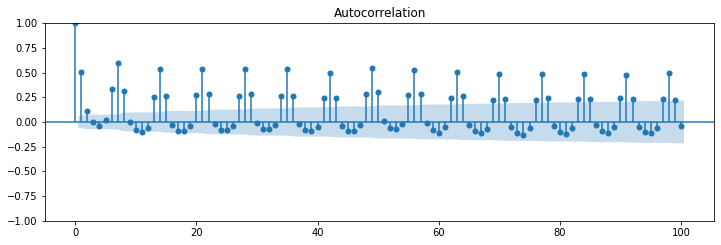

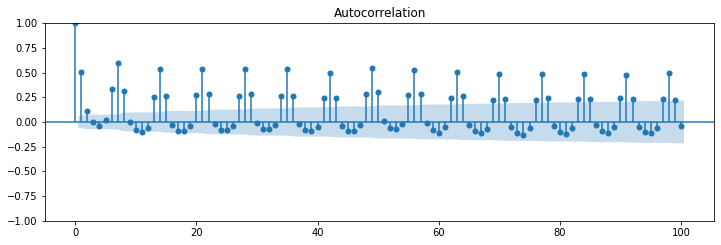

In [20]:
res.sum(axis=1)
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
plot_acf(res.sum(axis=1).values.squeeze(),
         lags=100,ax=ax1)

<AxesSubplot:>

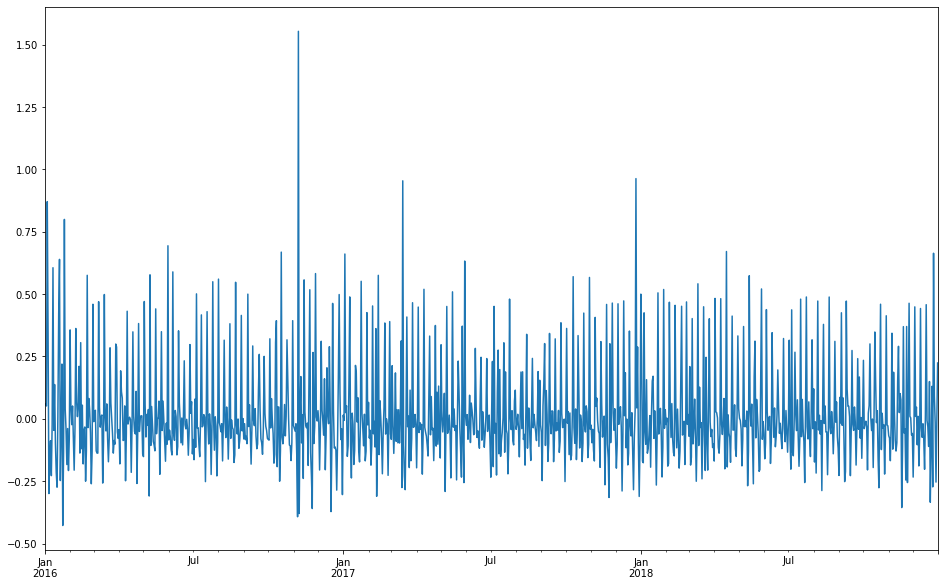

In [21]:
res.sum(axis=1).pct_change().plot(figsize=(16,10))

<AxesSubplot:>

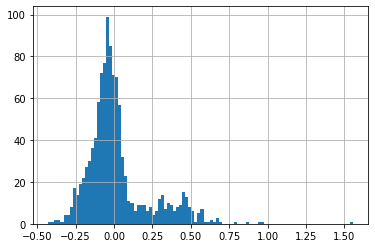

In [44]:
res.sum(axis=1).pct_change().hist(bins=100)

In [24]:
res.sum(axis=1).pct_change()

2016-01-01         NaN
2016-01-02    0.059096
2016-01-03    0.051422
2016-01-04    0.870552
2016-01-05    0.339008
                ...   
2018-12-27    0.091958
2018-12-28   -0.014364
2018-12-29   -0.253608
2018-12-30   -0.009188
2018-12-31    0.223725
Length: 1096, dtype: float64